In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('../data/SEOUL.csv')

In [3]:
data = data.groupby('상권_코드_명').mean().reset_index()

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
data_ = data.iloc[:, 4:]
scaled_data = scaler.fit_transform(data_)

In [18]:
data_final = scaled_data[:, :-1]

In [30]:
pd.DataFrame(data_final, columns=data_.columns[:-1])

,유사_업종_점포_수,개업_율,폐업_율,주중_매출_비율,주말_매출_비율,남성_매출_비율,여성_매출_비율,연령대_1020_매출_비율,연령대_3040_매출_비율,연령대_5060_매출_비율,집객시설_수,교통_인프라,총 상주인구 수,총_직장_인구_수,총_생활인구_수,월_평균_소득_금액
0,0.116040,0.400815,0.655204,0.766169,0.233831,0.421727,0.578273,0.298275,0.905799,0.181605,0.180851,0.282353,0.100258,0.108932,0.041315,0.540149
1,0.201054,0.185164,0.535261,0.518292,0.481708,0.556516,0.443484,0.165617,0.439187,0.594367,0.154255,0.035294,0.210621,0.126469,0.224915,0.526627
2,0.298743,0.272747,0.391938,0.275026,0.724974,0.064072,0.935928,0.540636,0.547104,0.185985,0.101064,0.035294,0.246495,0.080222,0.334202,0.546591
3,1.000000,0.179390,0.375315,0.507063,0.492937,0.515211,0.484789,0.183498,0.748343,0.384514,0.553191,1.000000,0.302342,1.000000,0.162022,0.367075
4,0.212359,0.186364,0.323398,0.606152,0.393848,0.275767,0.724233,0.269561,0.722566,0.322445,0.223404,0.117647,0.118822,0.095120,0.241622,0.610926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.017135,0.370152,0.487169,0.165314,0.834686,0.266283,0.733717,0.446878,0.619149,0.226070,0.045213,0.129412,0.268191,0.003428,0.246476,0.353157
109,0.070263,0.324018,0.591043,0.105223,0.894777,0.115840,0.884160,1.000000,0.177489,0.000000,0.000000,0.023529,0.038537,0.004366,0.067428,0.379635
110,0.006134,0.426417,0.364156,0.134227,0.865773,0.513397,0.486603,0.717357,0.508496,0.049566,0.000000,0.000000,0.044333,0.005648,0.108928,0.358212
111,0.561746,0.375869,0.605496,0.169612,0.830388,0.128839,0.871161,0.890110,0.320485,0.010315,0.231383,0.258824,0.374716,0.117984,0.568617,0.422963


In [19]:
from sklearn.cluster import KMeans

In [20]:
from itertools import combinations

In [21]:
import warnings
warnings.filterwarnings(action='ignore')

In [22]:
from sklearn import metrics

In [23]:
cols = data.columns[4:-1]

In [ ]:
from scipy.spatial import distance

def dunn_index(data, labels):
    
    clusters = np.unique(labels)
    num_clusters = len(clusters)
    
    intra_cluster_distances = []
    for cluster in clusters:
        cluster_points = data[labels == cluster]
        pairwise_distances = distance.pdist(cluster_points)
        if len(pairwise_distances) > 0:
            intra_cluster_distances.append(np.min(pairwise_distances))
    
    min_intra_cluster_distance = np.min(intra_cluster_distances)
    
    inter_cluster_distances = []
    for (cluster1, cluster2) in combinations(clusters, 2):
        cluster1_points = data[labels == cluster1]
        cluster2_points = data[labels == cluster2]
        pairwise_distances = distance.cdist(cluster1_points, cluster2_points)
        inter_cluster_distances.append(np.min(pairwise_distances))
    
    max_inter_cluster_distance = np.max(inter_cluster_distances)
    
    dunn_index = min_intra_cluster_distance / max_inter_cluster_distance
    
    return dunn_index

In [61]:
from sklearn import metrics

def test(X, n_cluster):
    
    pca = PCA()
    pca_data = pca.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init="auto").fit(X)
    labels = kmeans.labels_

    score_a = metrics.silhouette_score(pca_data[:, :3], labels, metric='euclidean')
    score_b = dunn_index(data_final, labels)
    
    return score_a, score_b

def test_plot(X, columns, n_cluster):
    
    pca = PCA()
    pca_data = pca.fit_transform(X)
    
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    loading_matrix = pd.DataFrame(loadings)
    loading_matrix = loading_matrix.iloc[:, :3]

    loading_matrix.columns = ['PC1', 'PC2', 'PC3']
    loading_matrix.index = cols[list(columns)]
        
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init="auto").fit(X)
    labels = kmeans.labels_
    
    plt.figure(figsize=[15,15])

    plt.subplot(2, 2, 1)
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(2, 2, 2)
    plt.scatter(pca_data[:, 0], pca_data[:, 2], c=labels)
    plt.xlabel('PC1')
    plt.ylabel('PC3')

    plt.subplot(2, 2, 3)
    plt.scatter(pca_data[:, 1], pca_data[:, 2], c=labels)
    plt.xlabel('PC2')
    plt.ylabel('PC3')

    plt.show()
    
    score = metrics.silhouette_score(pca_data[:, :3], labels, metric='euclidean')
    
    return loading_matrix, labels, score

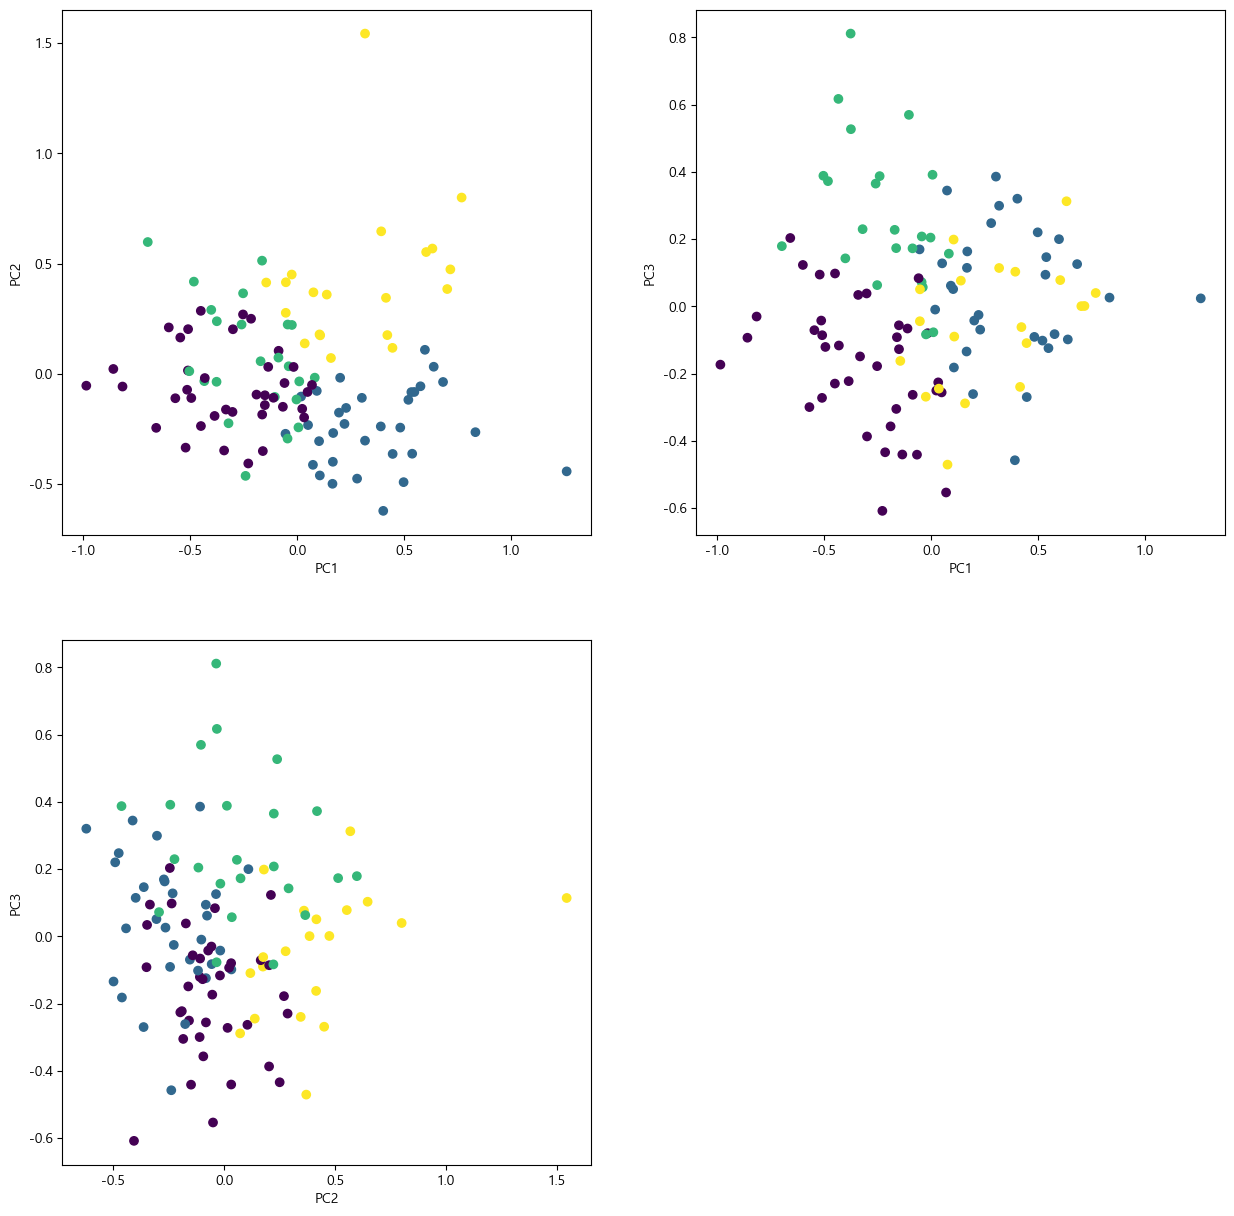

(                     PC1       PC2       PC3
 유사_업종_점포_수      0.094409  0.130843  0.012177
 개업_율           -0.062871 -0.020000  0.044492
 폐업_율           -0.114544 -0.020734  0.063919
 주중_매출_비율        0.164288 -0.010401 -0.009241
 주말_매출_비율       -0.164288  0.010401  0.009241
 남성_매출_비율        0.124370 -0.104994  0.112840
 여성_매출_비율       -0.124370  0.104994 -0.112840
 연령대_1020_매출_비율 -0.144562  0.034531  0.056742
 연령대_3040_매출_비율  0.071801  0.024733  0.010443
 연령대_5060_매출_비율  0.086407 -0.046869 -0.058104
 집객시설_수          0.047167  0.124651 -0.006291
 교통_인프라          0.032694  0.055498  0.003269
 총 상주인구 수       -0.012270  0.073049  0.134795
 총_직장_인구_수       0.114181  0.113718 -0.000396
 총_생활인구_수       -0.012642  0.136875  0.077259
 월_평균_소득_금액      0.058195  0.047473 -0.012423,
 array([1, 1, 0, 3, 3, 3, 1, 2, 1, 2, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 3, 3, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 3, 1, 1, 0, 0, 0,
        0, 1, 2, 2, 0, 1, 2, 0, 2, 1, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 2

In [62]:
test_plot(data_final, range(len(cols)), 4)

In [60]:
# num: 선택할 변수 개수
# cls_num: 클러스터 개수
# num과 cls_num의 값을 변경하며 최적의 클러스터 결과 도출

def repeat_cls(num, cls_num):
    lst = list(combinations(pd.DataFrame(data_final).columns, num))

    results_s = [None] * len(lst)
    results_d = [None] * len(lst)

    for i in range(len(lst)):
        s_s, s_d = test(data_final[:, lst[i]], cls_num)
        results_s[i] = s_s
        results_d[i] = s_d
        if i%100==0:
            print(i,'/', len(lst))
    
    result_df = pd.DataFrame({'silhouette_score': results_s, 'dunn_index': results_d})
    result_df['score_mean'] = (result_df['silhouette_score'] + result_df['dunn_index'])/2
    idx_max = result_df.score_mean.argmax()
    loading, labels, score = test_plot(data_final[:, lst[idx_max]], lst[idx_max], cls_num)
    
    return lst, result_df, loading, labels, score

0 / 1820
100 / 1820
200 / 1820
300 / 1820
400 / 1820
500 / 1820
600 / 1820
700 / 1820
800 / 1820
900 / 1820
1000 / 1820
1100 / 1820
1200 / 1820
1300 / 1820
1400 / 1820
1500 / 1820
1600 / 1820
1700 / 1820
1800 / 1820


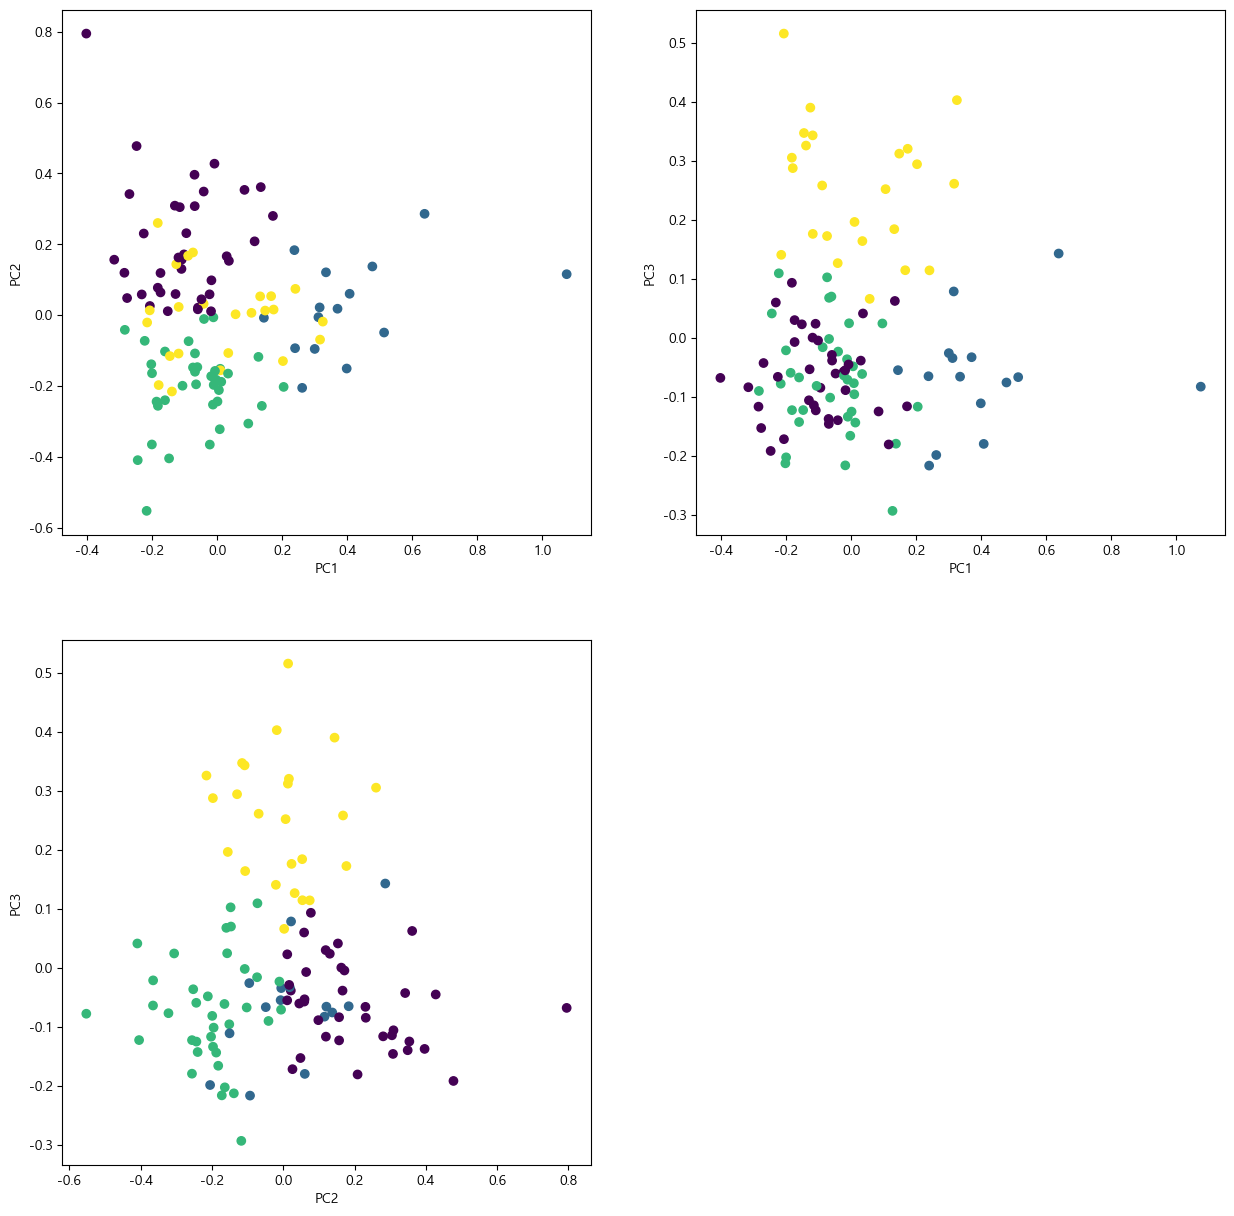

0.3332876137430527


In [67]:
lst4, results4, loading4, labels4, score4 = repeat_cls(4, 4)
print(score4)

0 / 4368
100 / 4368
200 / 4368
300 / 4368
400 / 4368
500 / 4368
600 / 4368
700 / 4368
800 / 4368
900 / 4368
1000 / 4368
1100 / 4368
1200 / 4368
1300 / 4368
1400 / 4368
1500 / 4368
1600 / 4368
1700 / 4368
1800 / 4368
1900 / 4368
2000 / 4368
2100 / 4368
2200 / 4368
2300 / 4368
2400 / 4368
2500 / 4368
2600 / 4368
2700 / 4368
2800 / 4368
2900 / 4368
3000 / 4368
3100 / 4368
3200 / 4368
3300 / 4368
3400 / 4368
3500 / 4368
3600 / 4368
3700 / 4368
3800 / 4368
3900 / 4368
4000 / 4368
4100 / 4368
4200 / 4368
4300 / 4368


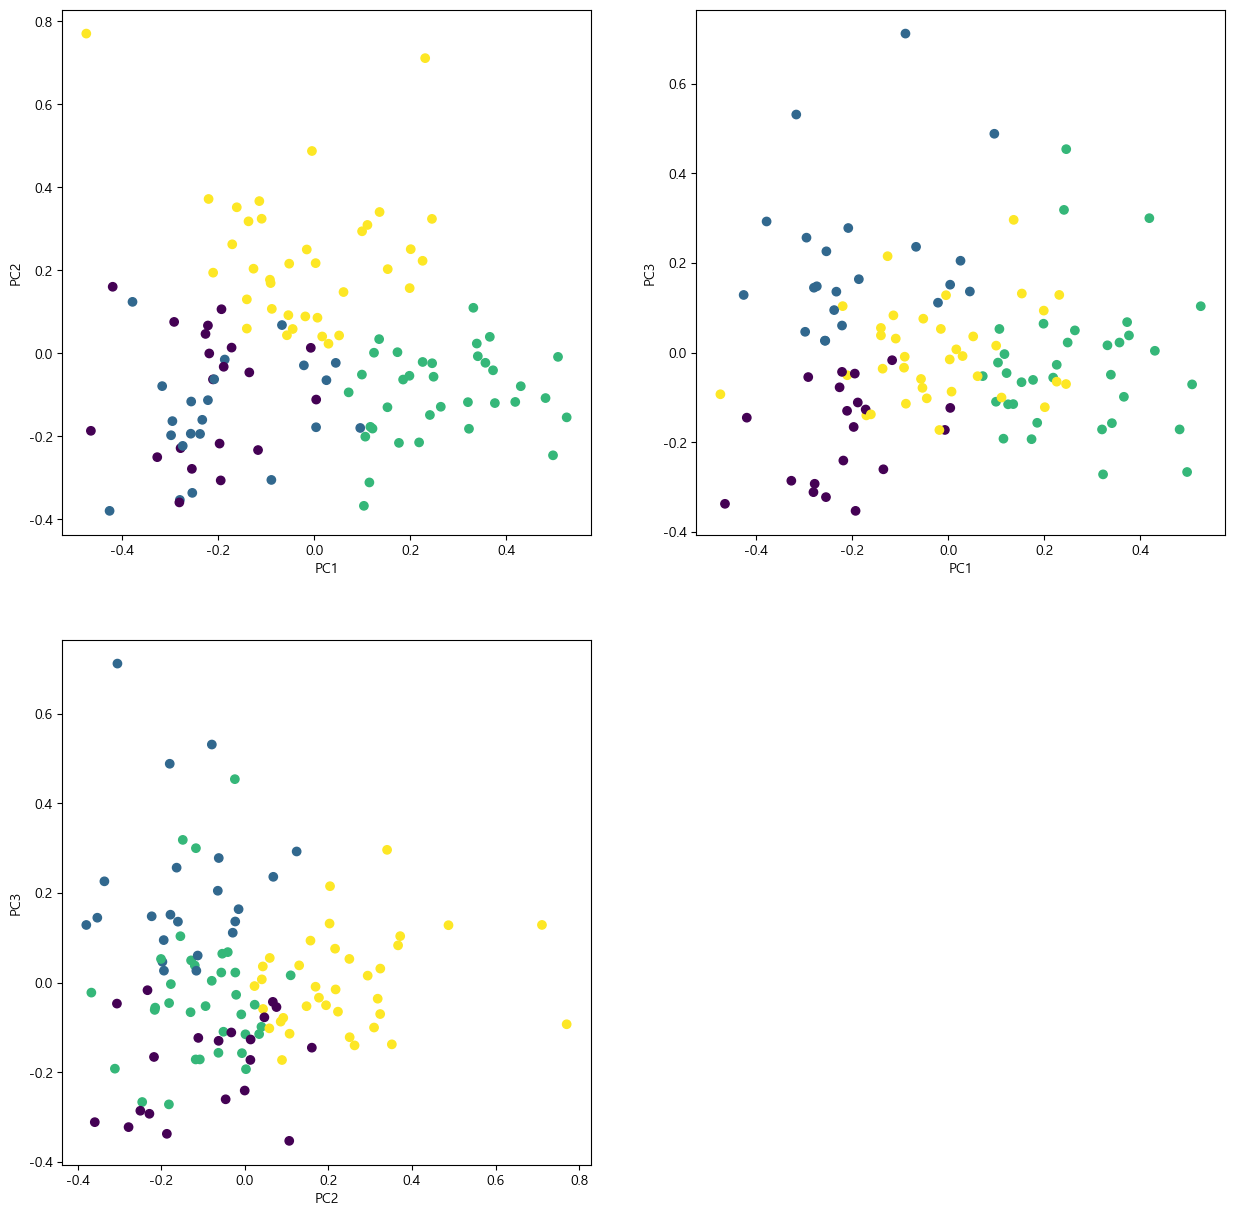

0.3069287669019442


In [68]:
lst5, results5, loading5, labels5, score5 = repeat_cls(5, 4)
print(score5)

0 / 8008
100 / 8008
200 / 8008
300 / 8008
400 / 8008
500 / 8008
600 / 8008
700 / 8008
800 / 8008
900 / 8008
1000 / 8008
1100 / 8008
1200 / 8008
1300 / 8008
1400 / 8008
1500 / 8008
1600 / 8008
1700 / 8008
1800 / 8008
1900 / 8008
2000 / 8008
2100 / 8008
2200 / 8008
2300 / 8008
2400 / 8008
2500 / 8008
2600 / 8008
2700 / 8008
2800 / 8008
2900 / 8008
3000 / 8008
3100 / 8008
3200 / 8008
3300 / 8008
3400 / 8008
3500 / 8008
3600 / 8008
3700 / 8008
3800 / 8008
3900 / 8008
4000 / 8008
4100 / 8008
4200 / 8008
4300 / 8008
4400 / 8008
4500 / 8008
4600 / 8008
4700 / 8008
4800 / 8008
4900 / 8008
5000 / 8008
5100 / 8008
5200 / 8008
5300 / 8008
5400 / 8008
5500 / 8008
5600 / 8008
5700 / 8008
5800 / 8008
5900 / 8008
6000 / 8008
6100 / 8008
6200 / 8008
6300 / 8008
6400 / 8008
6500 / 8008
6600 / 8008
6700 / 8008
6800 / 8008
6900 / 8008
7000 / 8008
7100 / 8008
7200 / 8008
7300 / 8008
7400 / 8008
7500 / 8008
7600 / 8008
7700 / 8008
7800 / 8008
7900 / 8008
8000 / 8008


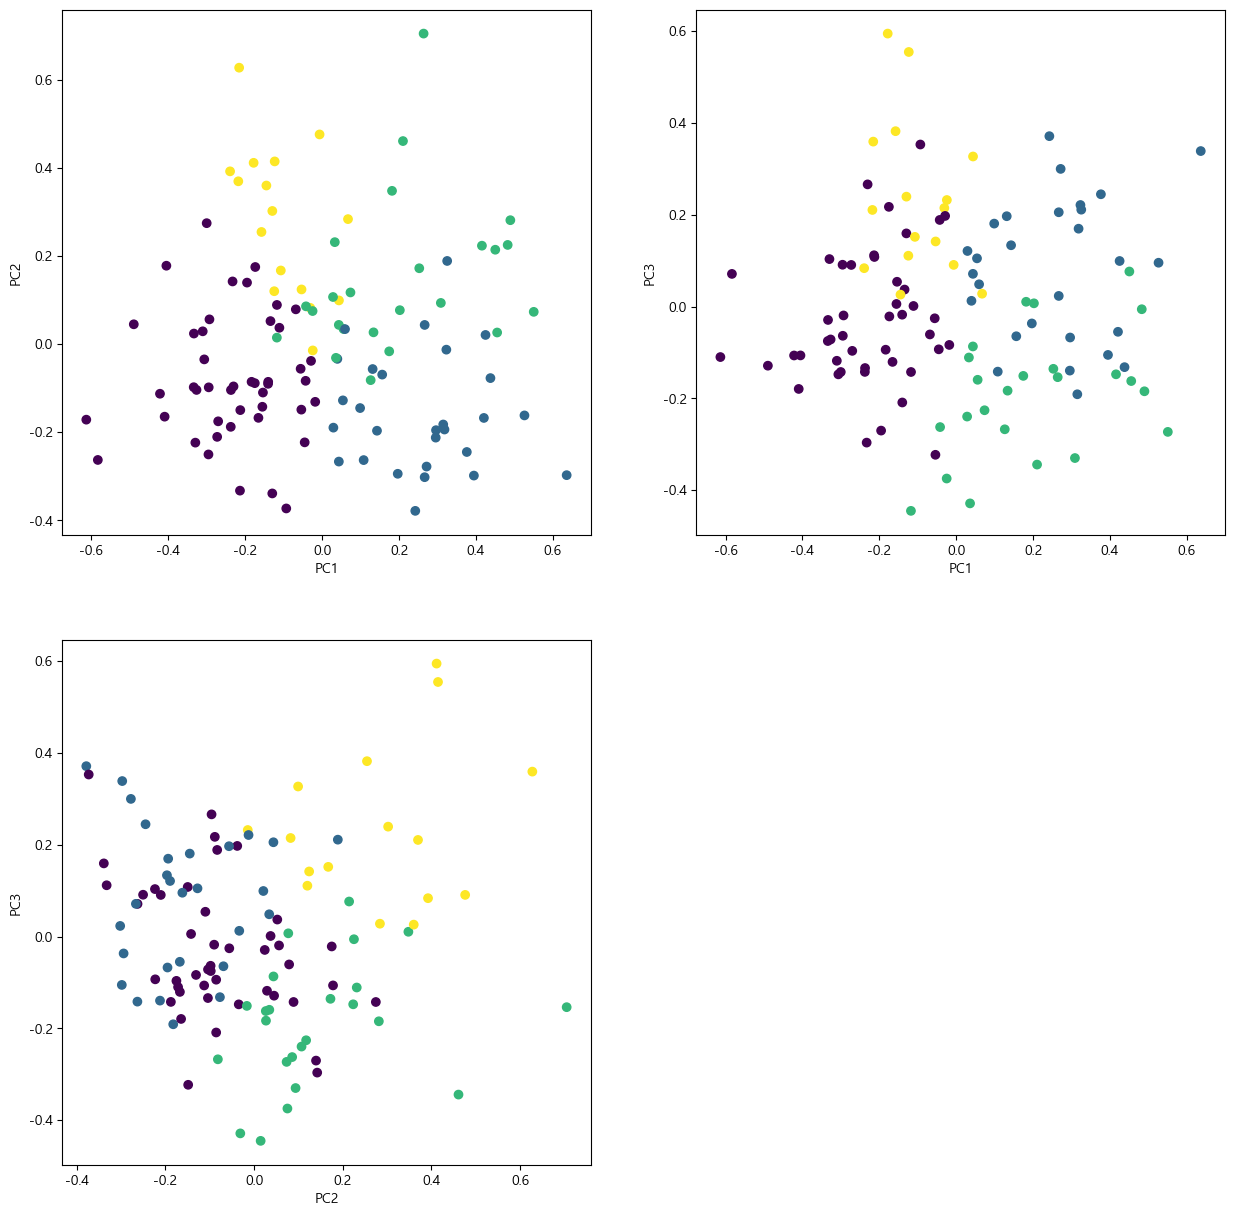

0.2959464555124533


In [69]:
lst6, results6, loading6, labels6, score6 = repeat_cls(6, 4)
print(score6)

0 / 11440
100 / 11440
200 / 11440
300 / 11440
400 / 11440
500 / 11440
600 / 11440
700 / 11440
800 / 11440
900 / 11440
1000 / 11440
1100 / 11440
1200 / 11440
1300 / 11440
1400 / 11440
1500 / 11440
1600 / 11440
1700 / 11440
1800 / 11440
1900 / 11440
2000 / 11440
2100 / 11440
2200 / 11440
2300 / 11440
2400 / 11440
2500 / 11440
2600 / 11440
2700 / 11440
2800 / 11440
2900 / 11440
3000 / 11440
3100 / 11440
3200 / 11440
3300 / 11440
3400 / 11440
3500 / 11440
3600 / 11440
3700 / 11440
3800 / 11440
3900 / 11440
4000 / 11440
4100 / 11440
4200 / 11440
4300 / 11440
4400 / 11440
4500 / 11440
4600 / 11440
4700 / 11440
4800 / 11440
4900 / 11440
5000 / 11440
5100 / 11440
5200 / 11440
5300 / 11440
5400 / 11440
5500 / 11440
5600 / 11440
5700 / 11440
5800 / 11440
5900 / 11440
6000 / 11440
6100 / 11440
6200 / 11440
6300 / 11440
6400 / 11440
6500 / 11440
6600 / 11440
6700 / 11440
6800 / 11440
6900 / 11440
7000 / 11440
7100 / 11440
7200 / 11440
7300 / 11440
7400 / 11440
7500 / 11440
7600 / 11440
7700 / 1144

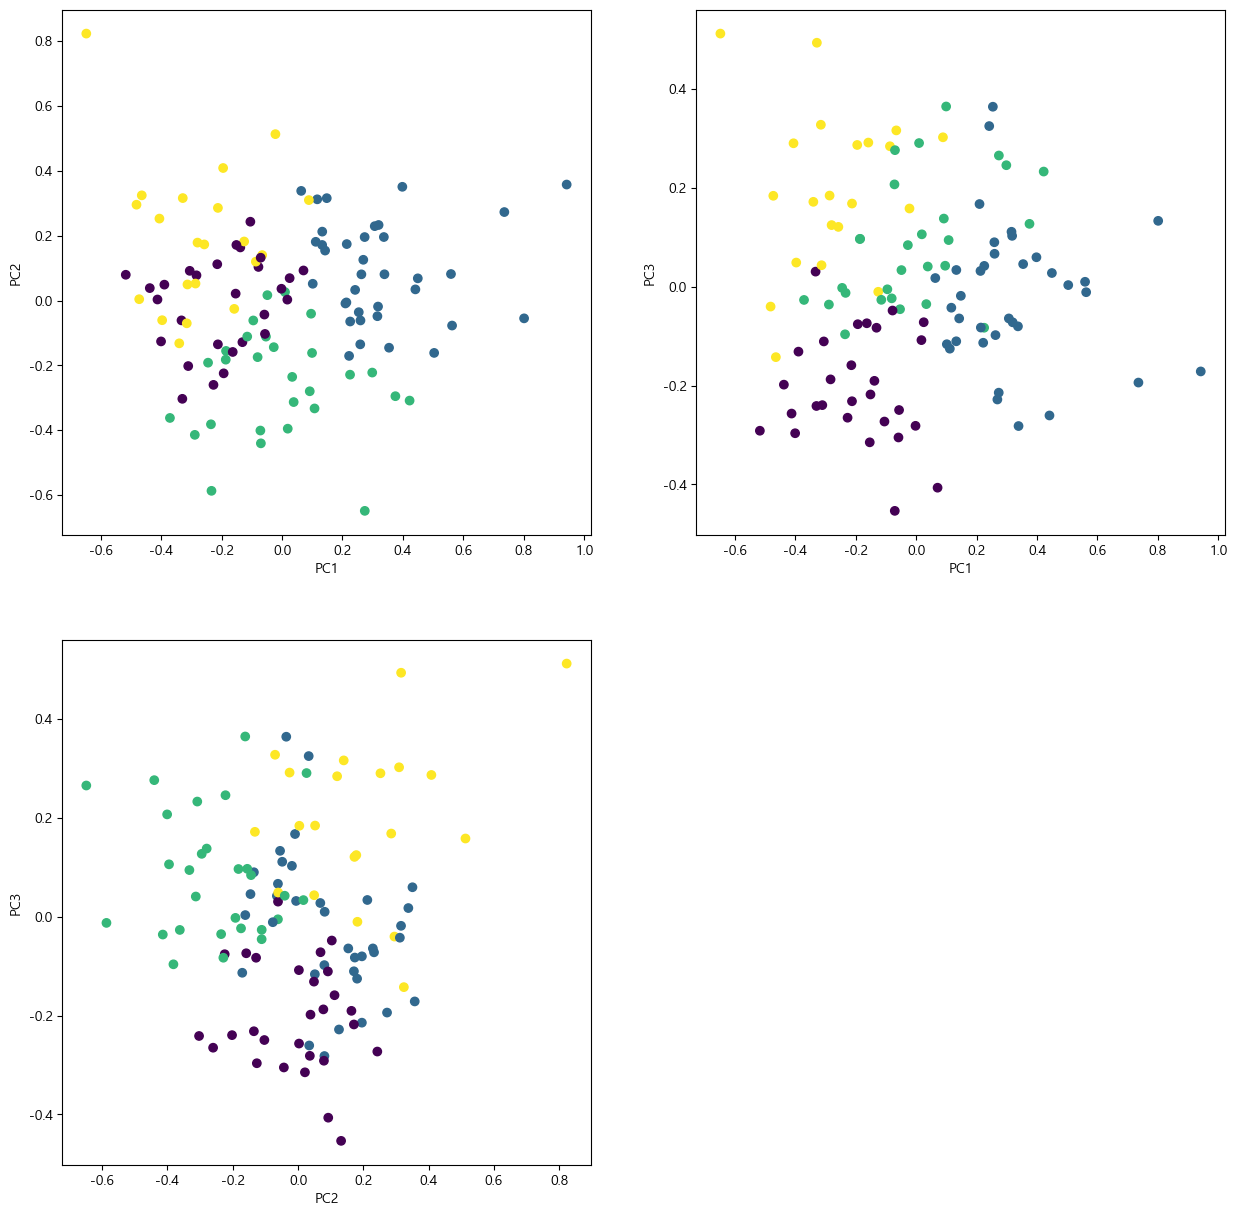

0.25600890005687366


In [70]:
lst7, results7, loading7, labels7, score7 = repeat_cls(7, 4)
print(score7)

0 / 12870
100 / 12870
200 / 12870
300 / 12870
400 / 12870
500 / 12870
600 / 12870
700 / 12870
800 / 12870
900 / 12870
1000 / 12870
1100 / 12870
1200 / 12870
1300 / 12870
1400 / 12870
1500 / 12870
1600 / 12870
1700 / 12870
1800 / 12870
1900 / 12870
2000 / 12870
2100 / 12870
2200 / 12870
2300 / 12870
2400 / 12870
2500 / 12870
2600 / 12870
2700 / 12870
2800 / 12870
2900 / 12870
3000 / 12870
3100 / 12870
3200 / 12870
3300 / 12870
3400 / 12870
3500 / 12870
3600 / 12870
3700 / 12870
3800 / 12870
3900 / 12870
4000 / 12870
4100 / 12870
4200 / 12870
4300 / 12870
4400 / 12870
4500 / 12870
4600 / 12870
4700 / 12870
4800 / 12870
4900 / 12870
5000 / 12870
5100 / 12870
5200 / 12870
5300 / 12870
5400 / 12870
5500 / 12870
5600 / 12870
5700 / 12870
5800 / 12870
5900 / 12870
6000 / 12870
6100 / 12870
6200 / 12870
6300 / 12870
6400 / 12870
6500 / 12870
6600 / 12870
6700 / 12870
6800 / 12870
6900 / 12870
7000 / 12870
7100 / 12870
7200 / 12870
7300 / 12870
7400 / 12870
7500 / 12870
7600 / 12870
7700 / 1287

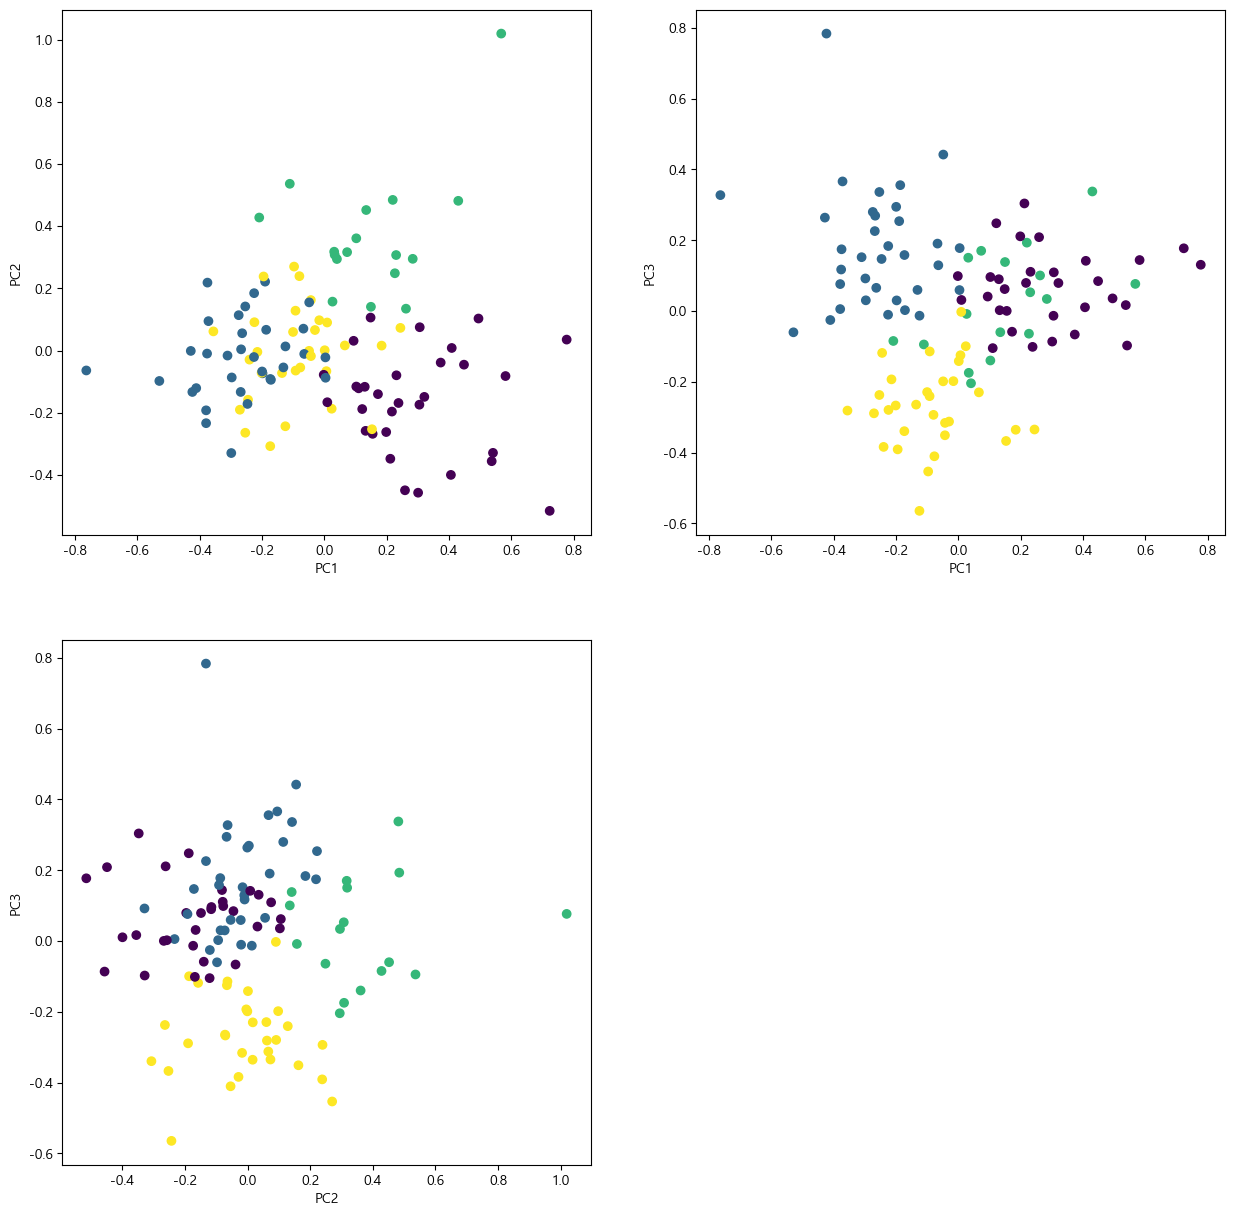

0.3378260950245825


In [71]:
lst8, results8, loading8, labels8, score8 = repeat_cls(8, 4)
print(score8)

0 / 11440
100 / 11440
200 / 11440
300 / 11440
400 / 11440
500 / 11440
600 / 11440
700 / 11440
800 / 11440
900 / 11440
1000 / 11440
1100 / 11440
1200 / 11440
1300 / 11440
1400 / 11440
1500 / 11440
1600 / 11440
1700 / 11440
1800 / 11440
1900 / 11440
2000 / 11440
2100 / 11440
2200 / 11440
2300 / 11440
2400 / 11440
2500 / 11440
2600 / 11440
2700 / 11440
2800 / 11440
2900 / 11440
3000 / 11440
3100 / 11440
3200 / 11440
3300 / 11440
3400 / 11440
3500 / 11440
3600 / 11440
3700 / 11440
3800 / 11440
3900 / 11440
4000 / 11440
4100 / 11440
4200 / 11440
4300 / 11440
4400 / 11440
4500 / 11440
4600 / 11440
4700 / 11440
4800 / 11440
4900 / 11440
5000 / 11440
5100 / 11440
5200 / 11440
5300 / 11440
5400 / 11440
5500 / 11440
5600 / 11440
5700 / 11440
5800 / 11440
5900 / 11440
6000 / 11440
6100 / 11440
6200 / 11440
6300 / 11440
6400 / 11440
6500 / 11440
6600 / 11440
6700 / 11440
6800 / 11440
6900 / 11440
7000 / 11440
7100 / 11440
7200 / 11440
7300 / 11440
7400 / 11440
7500 / 11440
7600 / 11440
7700 / 1144

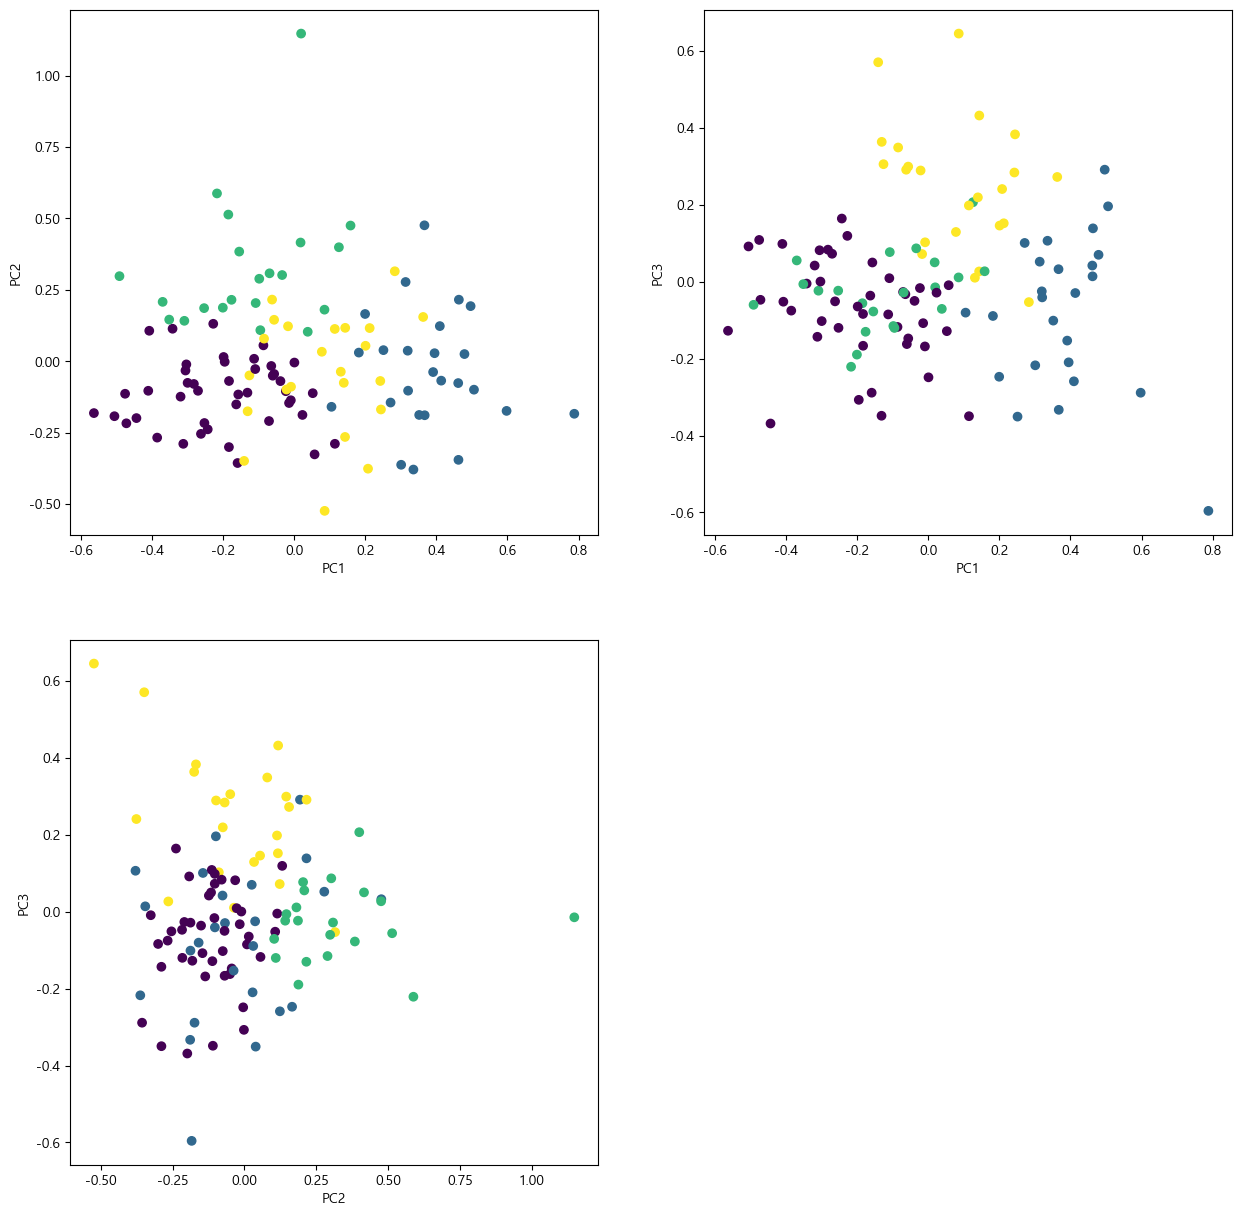

0.2687104187975765


In [72]:
lst9, results9, loading9, labels9, score9 = repeat_cls(9, 4)
print(score9)

0 / 8008
100 / 8008
200 / 8008
300 / 8008
400 / 8008
500 / 8008
600 / 8008
700 / 8008
800 / 8008
900 / 8008
1000 / 8008
1100 / 8008
1200 / 8008
1300 / 8008
1400 / 8008
1500 / 8008
1600 / 8008
1700 / 8008
1800 / 8008
1900 / 8008
2000 / 8008
2100 / 8008
2200 / 8008
2300 / 8008
2400 / 8008
2500 / 8008
2600 / 8008
2700 / 8008
2800 / 8008
2900 / 8008
3000 / 8008
3100 / 8008
3200 / 8008
3300 / 8008
3400 / 8008
3500 / 8008
3600 / 8008
3700 / 8008
3800 / 8008
3900 / 8008
4000 / 8008
4100 / 8008
4200 / 8008
4300 / 8008
4400 / 8008
4500 / 8008
4600 / 8008
4700 / 8008
4800 / 8008
4900 / 8008
5000 / 8008
5100 / 8008
5200 / 8008
5300 / 8008
5400 / 8008
5500 / 8008
5600 / 8008
5700 / 8008
5800 / 8008
5900 / 8008
6000 / 8008
6100 / 8008
6200 / 8008
6300 / 8008
6400 / 8008
6500 / 8008
6600 / 8008
6700 / 8008
6800 / 8008
6900 / 8008
7000 / 8008
7100 / 8008
7200 / 8008
7300 / 8008
7400 / 8008
7500 / 8008
7600 / 8008
7700 / 8008
7800 / 8008
7900 / 8008
8000 / 8008


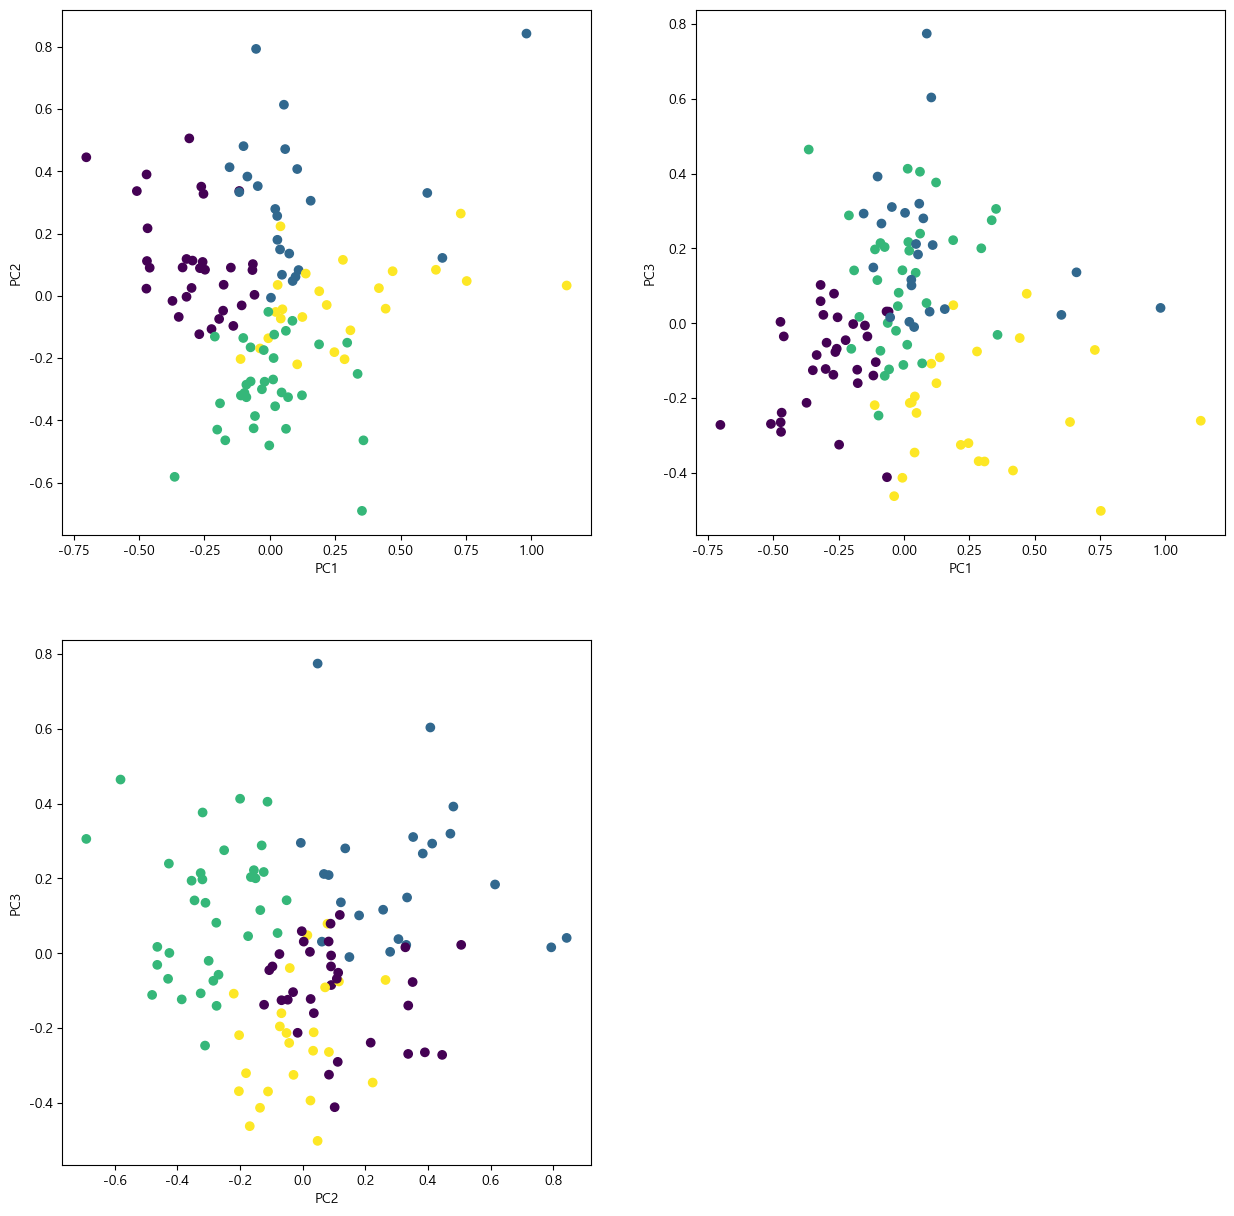

0.29299099549945806


In [73]:
lst10, results10, loading10, labels10, score10 = repeat_cls(10, 4)
print(score10)

0 / 4368
100 / 4368
200 / 4368
300 / 4368
400 / 4368
500 / 4368
600 / 4368
700 / 4368
800 / 4368
900 / 4368
1000 / 4368
1100 / 4368
1200 / 4368
1300 / 4368
1400 / 4368
1500 / 4368
1600 / 4368
1700 / 4368
1800 / 4368
1900 / 4368
2000 / 4368
2100 / 4368
2200 / 4368
2300 / 4368
2400 / 4368
2500 / 4368
2600 / 4368
2700 / 4368
2800 / 4368
2900 / 4368
3000 / 4368
3100 / 4368
3200 / 4368
3300 / 4368
3400 / 4368
3500 / 4368
3600 / 4368
3700 / 4368
3800 / 4368
3900 / 4368
4000 / 4368
4100 / 4368
4200 / 4368
4300 / 4368


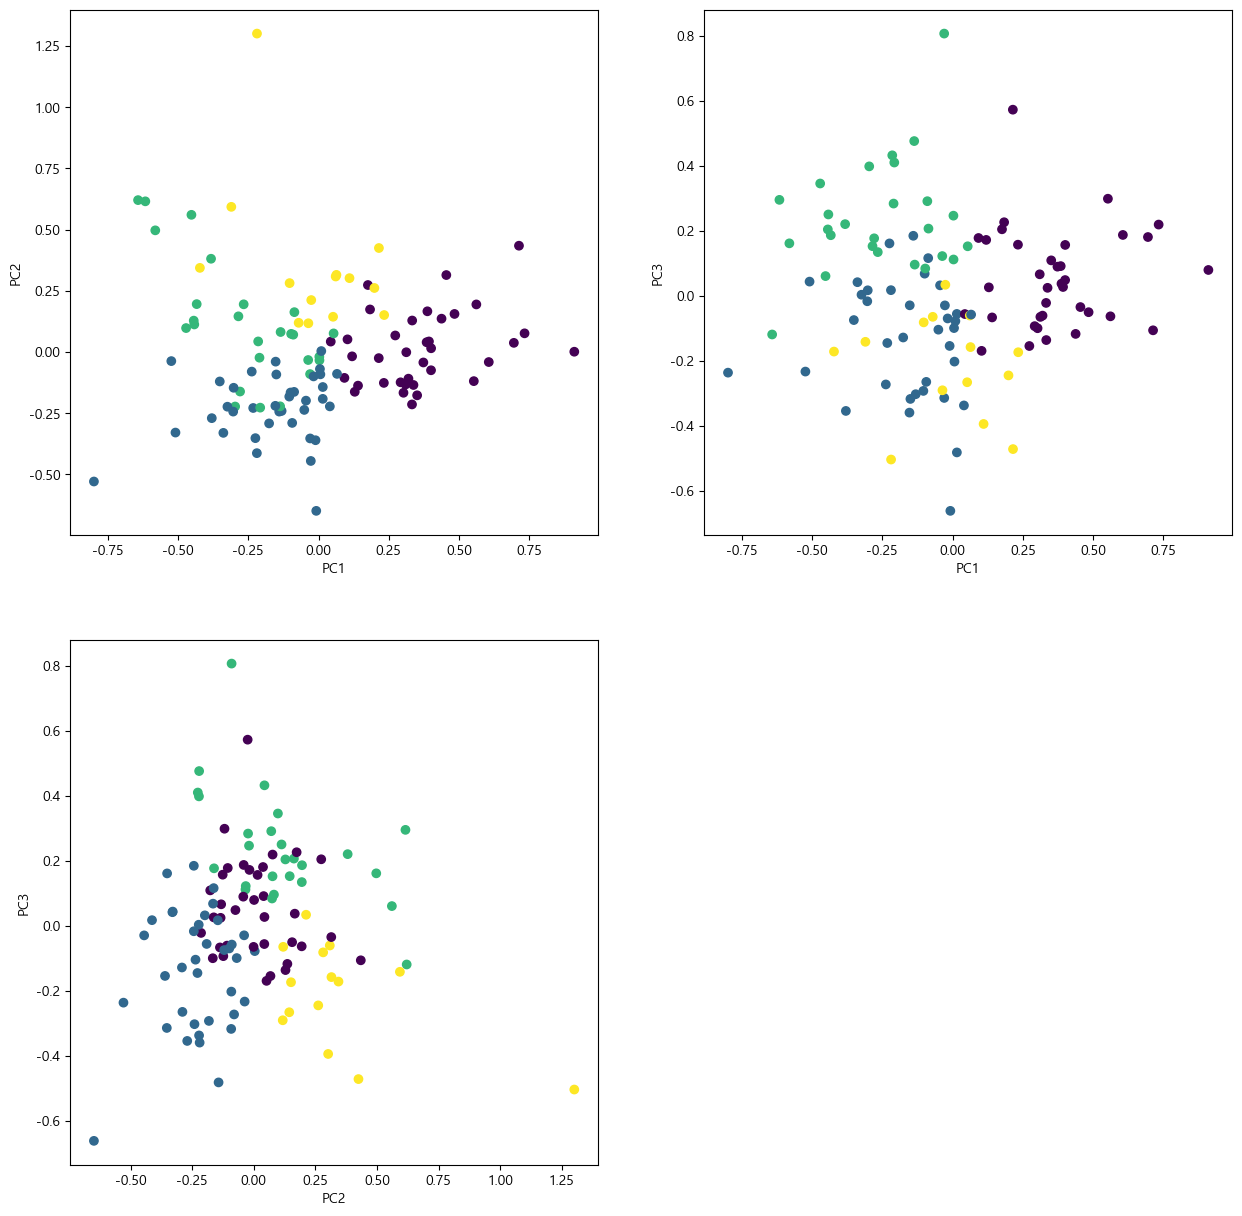

0.30309967216420164


In [74]:
lst11, results11, loading11, labels11, score11 = repeat_cls(11, 4)
print(score11)

0 / 1820
100 / 1820
200 / 1820
300 / 1820
400 / 1820
500 / 1820
600 / 1820
700 / 1820
800 / 1820
900 / 1820
1000 / 1820
1100 / 1820
1200 / 1820
1300 / 1820
1400 / 1820
1500 / 1820
1600 / 1820
1700 / 1820
1800 / 1820


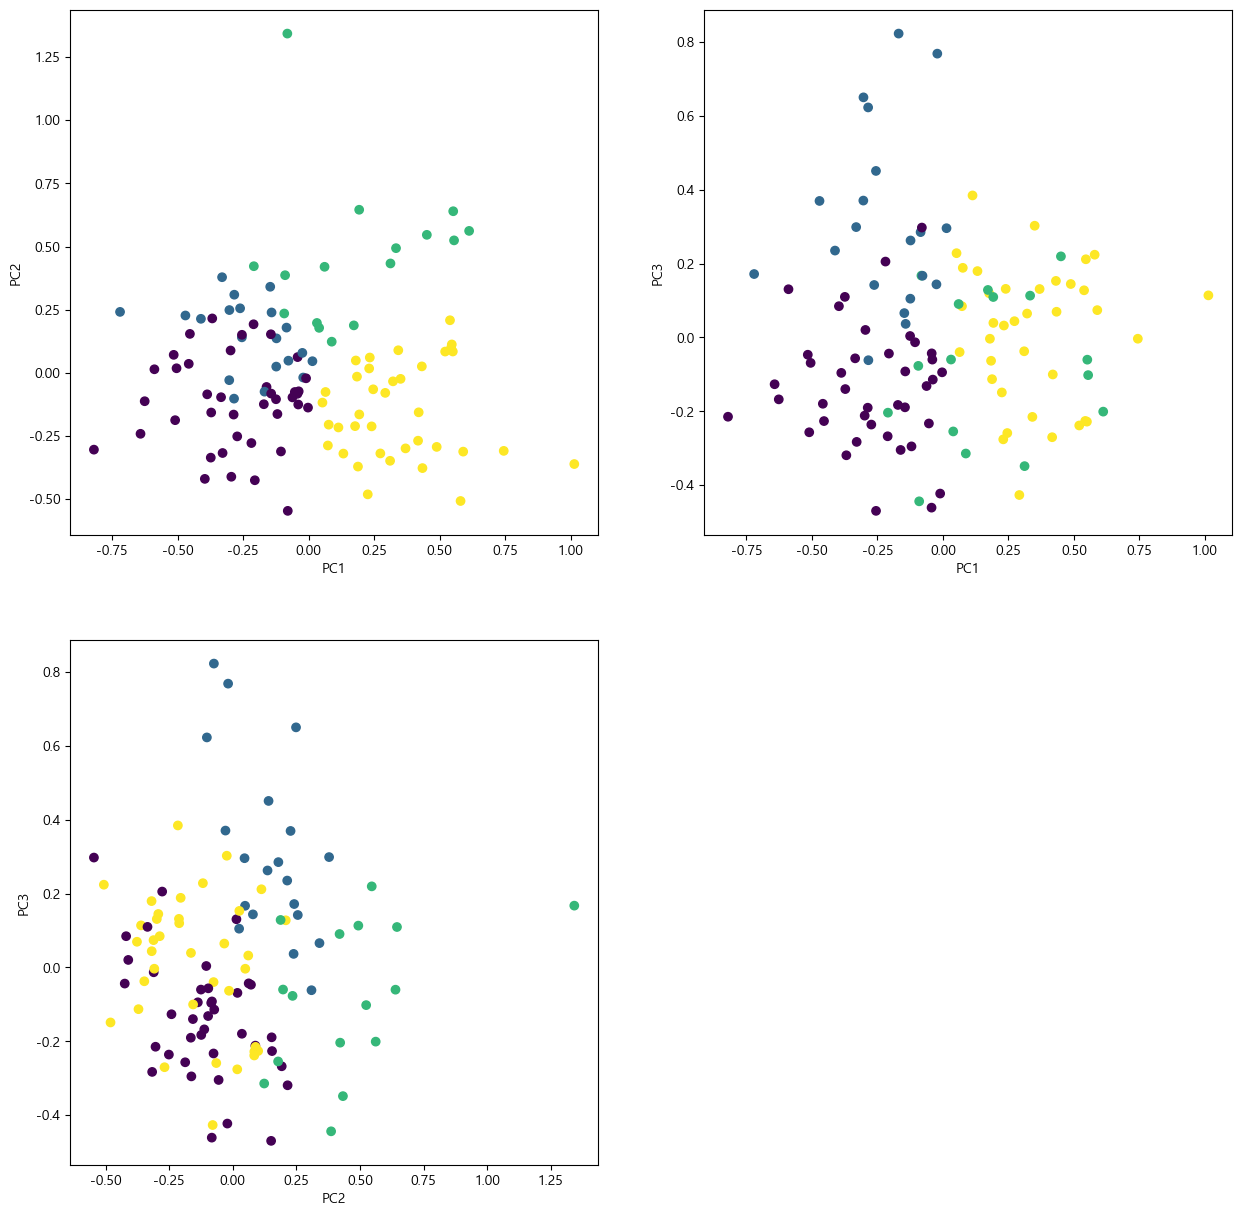

0.29862430701305537


In [75]:
lst12, results12, loading12, labels12, score12 = repeat_cls(12, 4)
print(score12)